In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


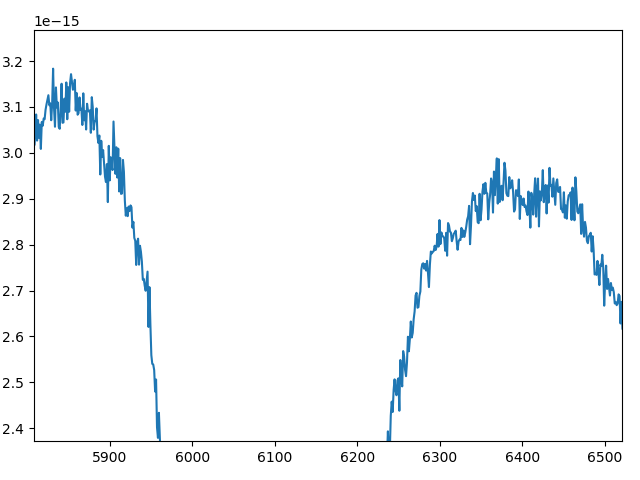

In [68]:
# read spec data
z = 0.00888
spec = '/Users/adamamiller/astronomy/ZTF/SN19yvq/data/spectra/ZTF19adcecwu_20200124_Keck1_v1.ascii'

spec_df = pd.read_csv(spec, comment='#', delim_whitespace=True, header=None)
wv = spec_df[0].values
fl = spec_df[1].values

plt.figure()
plt.plot(wv/(1+z), fl)
plt.tight_layout()

In [154]:
def lnlike_gaussian_abs(theta, vel_rf, norm_flux, 
                        delta_vel_components=[], flux_unc = 1):
    
    mean_vel, lnvar, amplitude = theta
    var_vel = np.exp(lnvar)
    
    model_flux = np.ones_like(vel_rf)
    model_flux += amplitude*1/np.sqrt(2*np.pi*var_vel)*np.exp(-1/(2*var_vel)*(vel_rf - mean_vel)**2)
    if len(delta_vel_components) > 0:
        for delta_vel in delta_vel_components:
            model_flux += amplitude*1/np.sqrt(2*np.pi*var_vel)*np.exp(-1/(2*var_vel)*((vel_rf-delta_vel) - mean_vel)**2)
    
    lnl = - 0.5*len(model_flux)*np.log(2*np.pi) - np.sum(np.log(flux_unc)) -0.5*np.sum((norm_flux - model_flux)**2 / flux_unc**2) 
    
    return lnl

def neg_lnlike_gaussian_abs(theta, vel_rf, norm_flux, 
                        delta_vel_components=[], flux_unc = 1):
    lnl = lnlike_gaussian_abs(theta, vel_rf, norm_flux, 
                              delta_vel_components=delta_vel_components, 
                              flux_unc = flux_unc)
    return -1*lnl

In [91]:
def divide_continuum(lambda_rf, flux, blue_continuum, red_continuum):
    '''Divide out linear continuum factor'''
    
    linear_continuum = lambda slope, wave, wave0, flux0: slope*(wave - wave0) + flux0
    
    slope = (blue_continuum[1]-red_continuum[1])/(blue_continuum[0] - red_continuum[0])
    norm_flux = flux/linear_continuum(slope, lambda_rf, blue_continuum[0], blue_continuum[1])
    
    return norm_flux

In [92]:
norm_flux = divide_continuum(wv/(1+z), fl, (5853, 3.11e-15), (6373,2.94e-15))

<IPython.core.display.Javascript object>


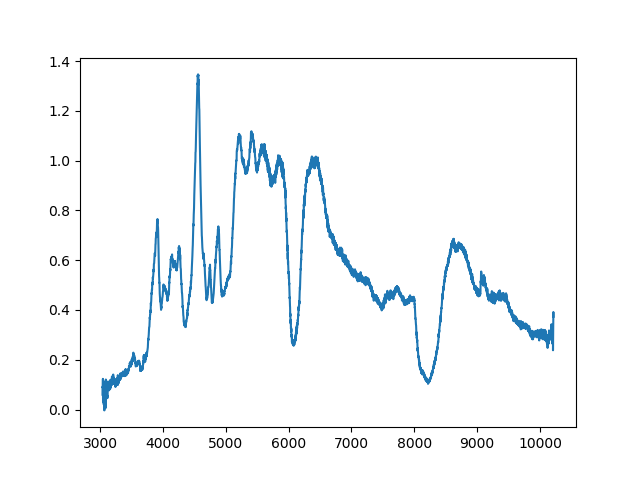

In [93]:
plt.figure()
plt.plot(wv/(1+z), norm_flux)

In [94]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c*((lambda_rf/lambda_0)**2 - 1)/((lambda_rf/lambda_0)**2 + 1)
    
    return v

<IPython.core.display.Javascript object>


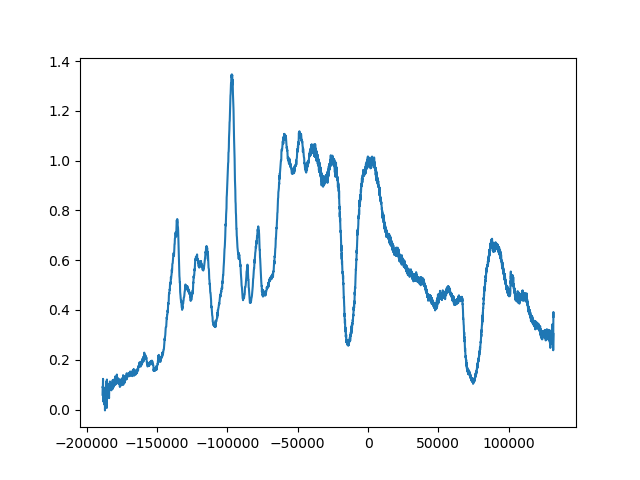

In [95]:
plt.figure()
vel_rf= velocity_rf(wv/(1+z), 6371.37)

plt.plot(vel_rf_6371, norm_flux)

In [96]:
delta_vel = velocity_rf(6371.37, 6347.11)
delta_vel

1143.6804664041479

In [160]:
theta = (-13948.85294071,     16.72429935,  -4151.29351502)
# theta = (-14000, np.log(16e6), -8e3)

line_region = np.where((wv/(1+z) > 5853) & 
                       (wv/(1+z) < 6373))
lnlike_gaussian_abs(theta, vel_rf[line_region], 
                        norm_flux[line_region], 
                        delta_vel_components=[delta_vel])

-415.5314131827034

<IPython.core.display.Javascript object>


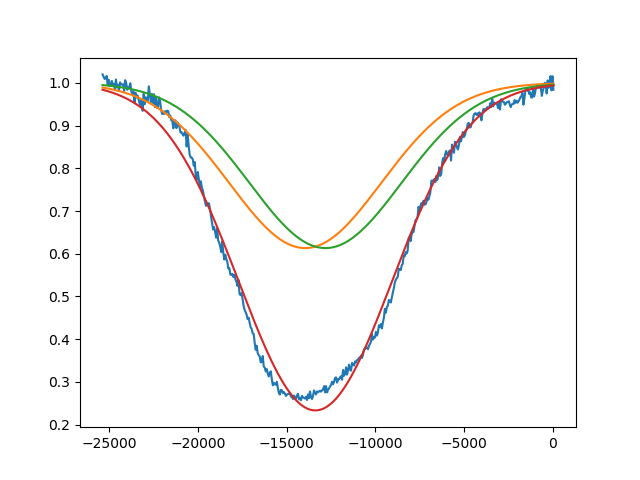

In [161]:
mean, lnvar, amp = theta
var = np.exp(lnvar)

plt.figure()
plt.plot(vel_rf[line_region], norm_flux[line_region])
plt.plot(vel_rf[line_region], 1 + calc_gauss(vel_rf[line_region], 
                                              mean, var, amp))
plt.plot(vel_rf[line_region], 1 + calc_gauss(vel_rf[line_region], 
                                              mean+delta_vel, var, amp))
plt.plot(vel_rf[line_region], 1 + calc_gauss(vel_rf[line_region], 
                                              mean+delta_vel, var, amp) + calc_gauss(vel_rf[line_region], 
                                              mean, var, amp))

In [58]:
def calc_gauss(x, mean, var, amp):
    return amp/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x-mean)**2/var)

In [155]:
from scipy.optimize import minimize

ml_res = minimize(neg_lnlike_gaussian_abs, (-14000, np.log(16e6), -8e3), method='Powell', # Powell method does not need derivatives
                      args=(vel_rf[line_region], norm_flux[line_region], [delta_vel]))

In [156]:
ml_res

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.32736929e+00, -7.01800123e-01, -4.04549805e+02],
       [ 2.76419239e+02, -3.68276830e-01,  8.46431291e+02]])
     fun: 415.5314131827042
 message: 'Optimization terminated successfully.'
    nfev: 187
     nit: 5
  status: 0
 success: True
       x: array([-13948.85294071,     16.72429935,  -4151.29351502])

In [144]:
np.exp(16.72726113)

18388961.608901985